# Example Processing Pipelines

First we need to load all libraries and dependencies

In [1]:
import opencortex.neuroengine.flux.base.operators  # Enable >>
from opencortex.neuroengine.flux.preprocessing.bandpass import BandPassFilterNode
from opencortex.neuroengine.flux.preprocessing.notch import NotchFilterNode
from opencortex.utils.loader import load_data, convert_to_mne
import matplotlib.pyplot as plt
import numpy as np

fs = 250
chs = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]

eeg, trigger, dataframe = load_data("../data/aep/auditory_erp_eyes_open_S1.csv", fs=fs, skiprows=5, delimiter=',')
print("Loaded data with shape:" + str(eeg.shape) + " and trigger shape: " + str(trigger.shape))
print("That means we have " + str(eeg.shape[0]) + " samples and " + str(eeg.shape[1]) + " channels.")

# Convert to MNE format
raw_data = convert_to_mne(eeg, trigger, fs=fs, chs=chs,
                          recompute=False)  # recompute=True to recalculate the event labels if the values are negative

Loaded data with shape:(13626, 8) and trigger shape: (13626,)
That means we have 13626 samples and 8 channels.
Creating RawArray with float64 data, n_channels=8, n_times=13626
    Range : 0 ... 13625 =      0.000 ...    54.500 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=13626
    Range : 0 ... 13625 =      0.000 ...    54.500 secs
Ready.


## Filtering Example
In this example, we show how to concatenate basic filtering nodes

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\miche\Desktop\projects\OpenCortexBCI\.venv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


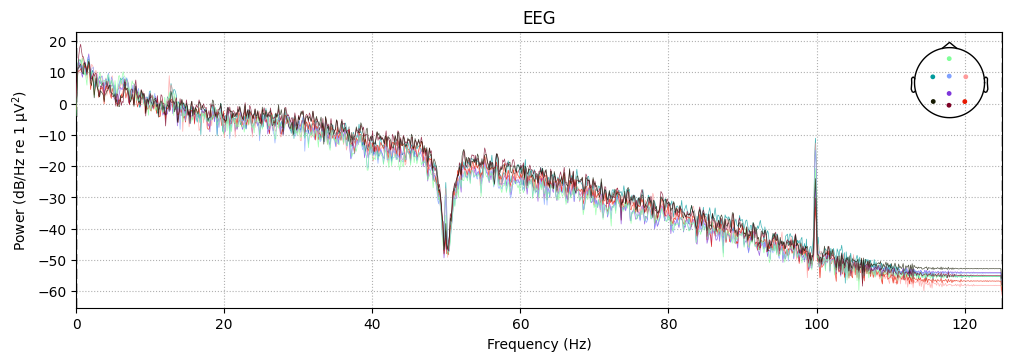

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.50 Hz
- Upper transition bandwidth: 3.50 Hz
- Filter length: 237 samples (0.948 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 825 samples (3.300 s)

Effective window size : 

C:\Users\miche\Desktop\projects\OpenCortexBCI\.venv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


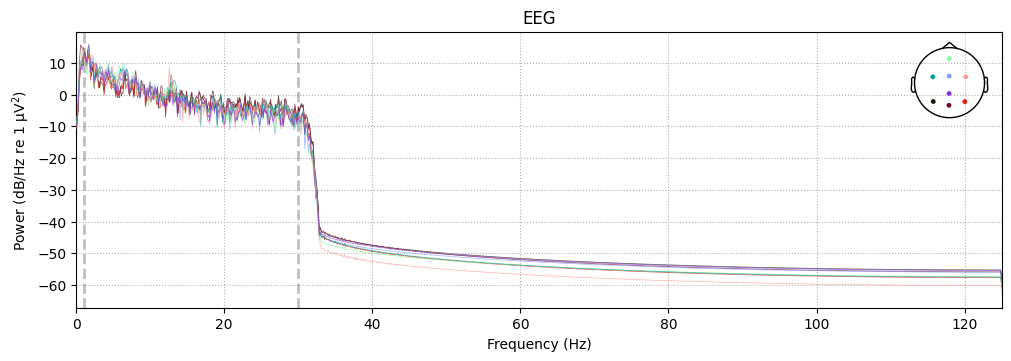

In [2]:
Pxx = raw_data.compute_psd(fmin=0, fmax=fs / 2)
Pxx.plot()
plt.show()

preprocessing = NotchFilterNode((50, 60)) >> BandPassFilterNode(1.0, 30.0)
filtered_data = preprocessing(raw_data)

Pxx = filtered_data.compute_psd(fmin=0, fmax=fs / 2)
Pxx.plot()
plt.show()

# Scaling Example
In this example, we show the effect of different scaling techniques


Applying sklearn StandardScaler pipeline...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.50 Hz
- Upper transition bandwidth: 3.50 Hz
- Filter length: 237 samples (0.948 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 

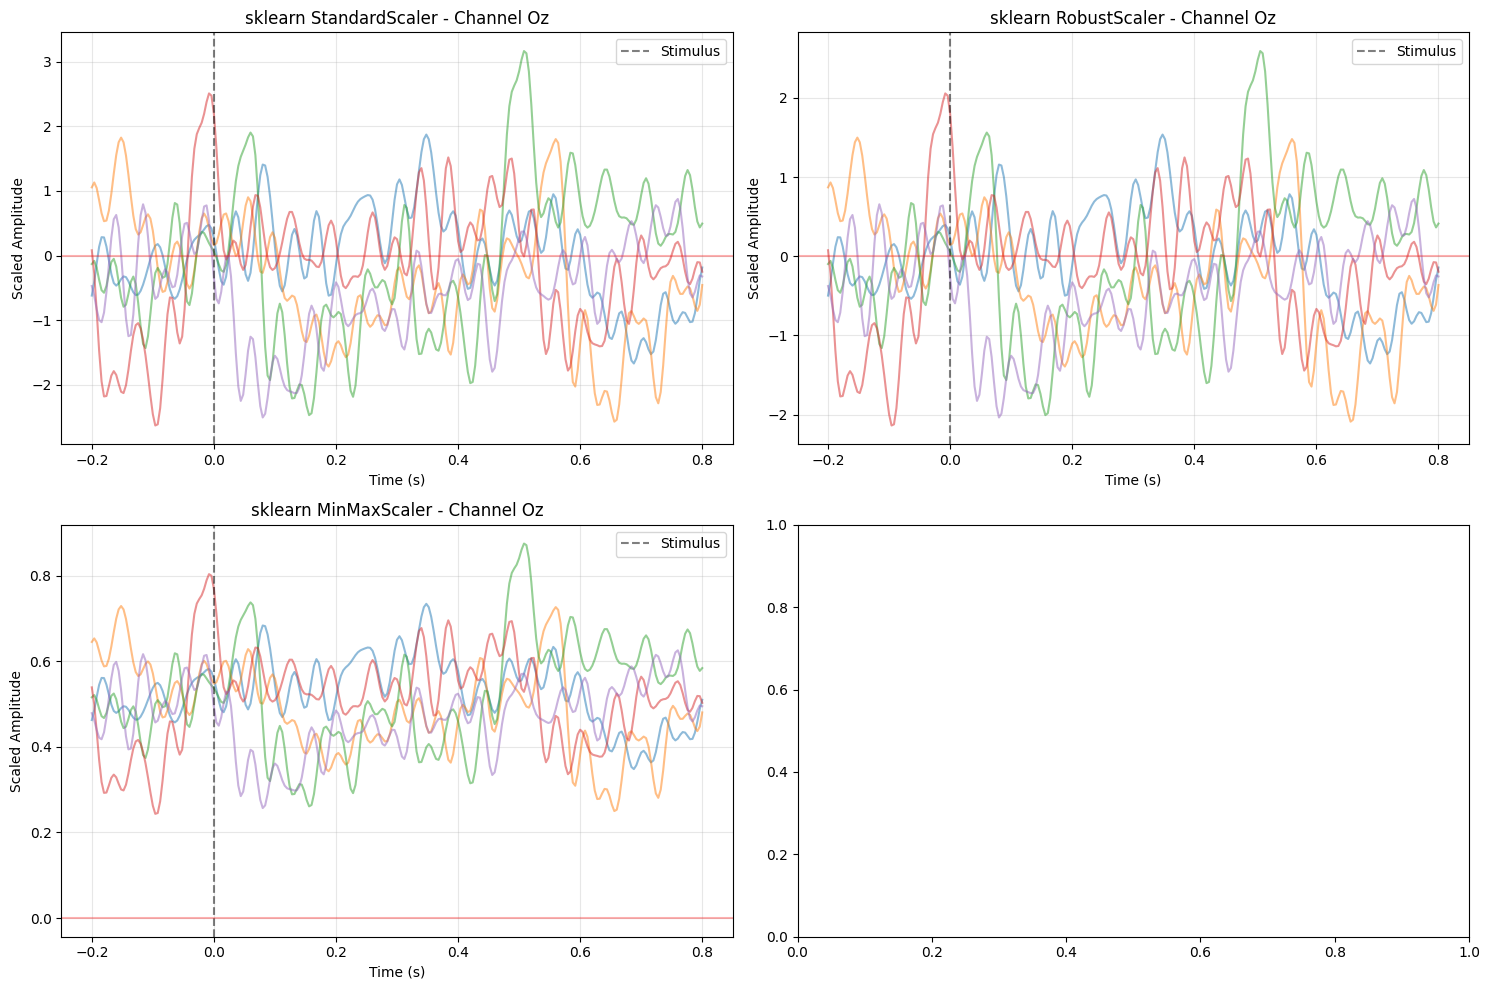

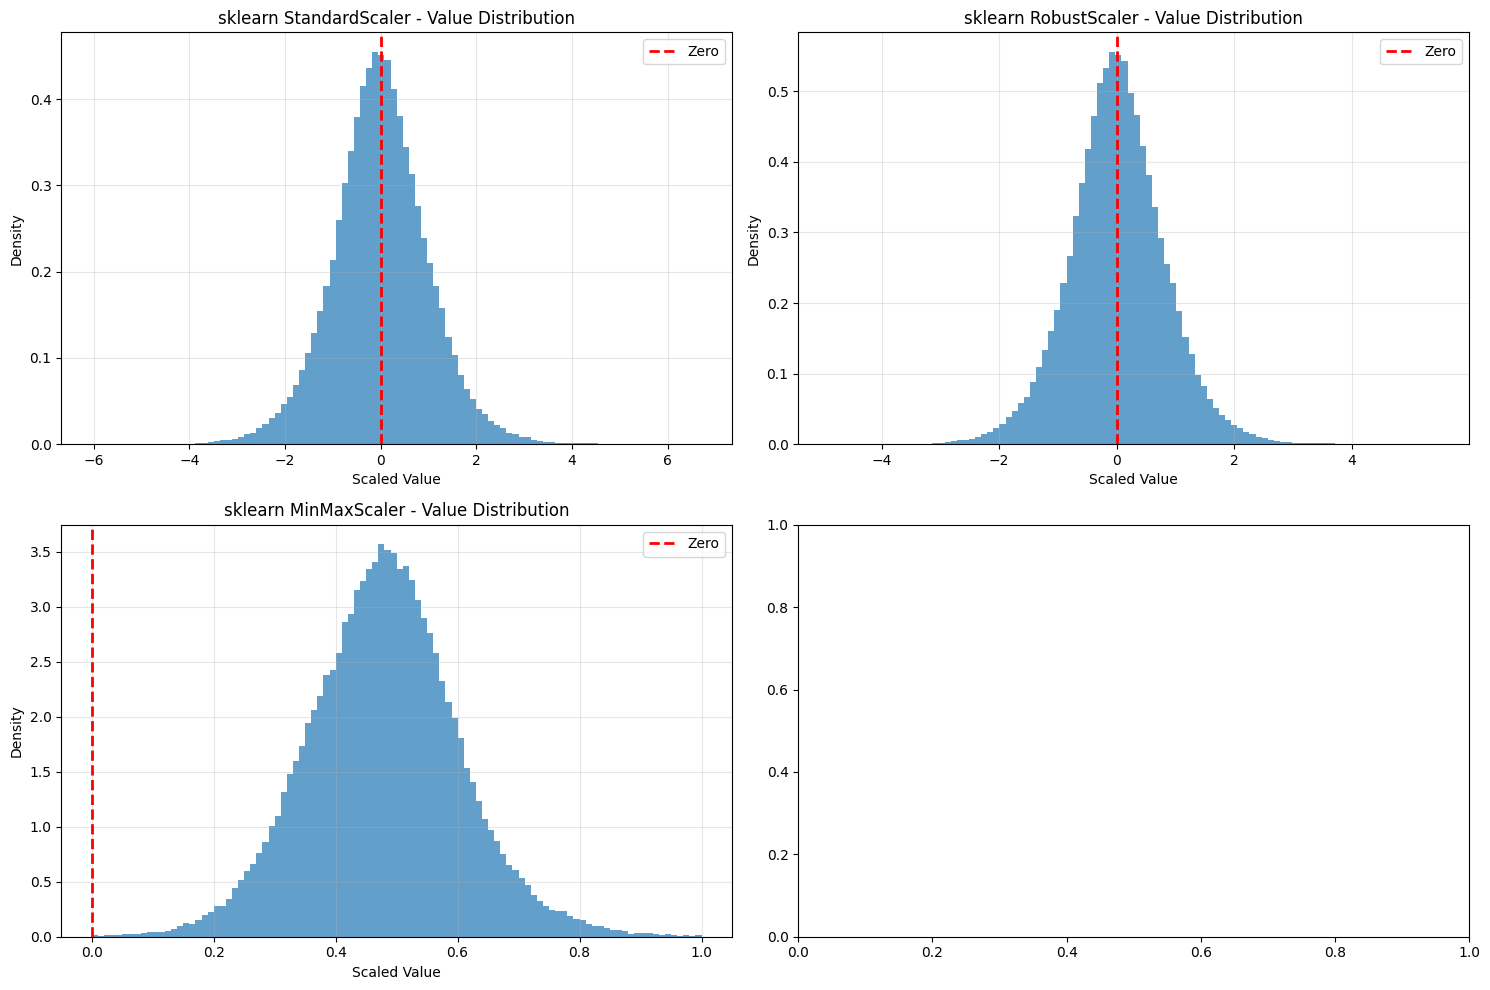

In [3]:
from opencortex.neuroengine.flux.preprocessing.scaler import ScalerNode
from opencortex.neuroengine.flux.preprocessing.extract import ExtractNode
from opencortex.neuroengine.flux.preprocessing.epochs import EpochingNode
from opencortex.neuroengine.flux.preprocessing.events import ExtractEventsNode, FilterEventsNode, RelabelEventsNode
from opencortex.neuroengine.flux.base.sequential import Sequential
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

# Example 1: Using sklearn StandardScaler
pipeline_sklearn_standard = Sequential(
    NotchFilterNode((50, 60), name="PowerlineNotch"),
    BandPassFilterNode(0.1, 30.0, name="ERPBand"),
    ExtractEventsNode(stim_channel='STI', auto_label=True, name="EventExtractor"),
    FilterEventsNode(max_event_id=90, name="EventFilter"),
    RelabelEventsNode(target_class=1, nontarget_label=3, name="EventRelabeler"),
    EpochingNode(
        tmin=-0.2,
        tmax=0.8,
        baseline=(-0.1, 0.0),
        event_id={'T': 1, 'NT': 3},
        name="Epocher"
    ),
    ExtractNode(
        label_encoder=LabelEncoder(),
        apply_label_encoding=True,
        label_mapping={1: 0, 3: 1},
        name="ExtractXy"
    ),
    ScalerNode(
        scaler=StandardScaler(),
        per_channel=True,
        name="SklearnStandardScaler"
    ),
    name="Pipeline_SklearnStandard"
)

# Example 2: Using sklearn RobustScaler
pipeline_sklearn_robust = Sequential(
    NotchFilterNode((50, 60), name="PowerlineNotch"),
    BandPassFilterNode(0.1, 30.0, name="ERPBand"),
    ExtractEventsNode(stim_channel='STI', auto_label=True, name="EventExtractor"),
    FilterEventsNode(max_event_id=90, name="EventFilter"),
    RelabelEventsNode(target_class=1, nontarget_label=3, name="EventRelabeler"),
    EpochingNode(
        tmin=-0.2,
        tmax=0.8,
        baseline=(-0.1, 0.0),
        event_id={'T': 1, 'NT': 3},
        name="Epocher"
    ),
    ExtractNode(
        label_encoder=LabelEncoder(),
        apply_label_encoding=True,
        label_mapping={1: 0, 3: 1},
        name="ExtractXy"
    ),
    ScalerNode(
        scaler=RobustScaler(),
        per_channel=True,
        name="SklearnRobustScaler"
    ),
    name="Pipeline_SklearnRobust"
)

# Example 4: Using sklearn MinMaxScaler
pipeline_sklearn_minmax = Sequential(
    NotchFilterNode((50, 60), name="PowerlineNotch"),
    BandPassFilterNode(0.1, 30.0, name="ERPBand"),
    ExtractEventsNode(stim_channel='STI', auto_label=True, name="EventExtractor"),
    FilterEventsNode(max_event_id=90, name="EventFilter"),
    RelabelEventsNode(target_class=1, nontarget_label=3, name="EventRelabeler"),
    EpochingNode(
        tmin=-0.2,
        tmax=0.8,
        baseline=(-0.1, 0.0),
        event_id={'T': 1, 'NT': 3},
        name="Epocher"
    ),
    ExtractNode(
        label_encoder=LabelEncoder(),
        apply_label_encoding=True,
        label_mapping={1: 0, 3: 1},
        name="ExtractXy"
    ),
    ScalerNode(
        scaler=MinMaxScaler(),
        per_channel=True,
        name="SklearnMinMaxScaler"
    ),
    name="Pipeline_MinMaxScaler"
)

# Apply all pipelines
print("\nApplying sklearn StandardScaler pipeline...")
X_sklearn_std, y1 = pipeline_sklearn_standard(raw_data)

print("\nApplying sklearn RobustScaler pipeline...")
X_sklearn_rob, y2 = pipeline_sklearn_robust(raw_data)

print("\nApplying sklearn MinMaxScaler pipeline...")
X_sklearn_minmax, y4 = pipeline_sklearn_minmax(raw_data)

print(f"\n" + "=" * 60)
print("Scaler Comparison Results:")
print("=" * 60)

scalers_data = [
    ("sklearn StandardScaler", X_sklearn_std),
    ("sklearn RobustScaler", X_sklearn_rob),
    ("sklearn MinMaxScaler", X_sklearn_minmax),
]

for scaler_name, X_scaled in scalers_data:
    print(f"\n{scaler_name}:")
    print(f"  Shape: {X_scaled.shape}")
    print(f"  Mean:  {X_scaled.mean():.6f}")
    print(f"  Std:   {X_scaled.std():.6f}")
    print(f"  Min:   {X_scaled.min():.6f}")
    print(f"  Max:   {X_scaled.max():.6f}")

# ========================================================================
# Visualize scaler comparison
# ========================================================================
print("\n" + "=" * 60)
print("Creating scaler comparison visualization")
print("=" * 60)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Choose a representative channel and epoch
channel_idx = 6  # Cz
epoch_idx = 0

times = np.linspace(-0.2, 0.8, X_sklearn_std.shape[2])

for idx, (scaler_name, X_scaled) in enumerate(scalers_data):
    ax = axes[idx]

    # Plot multiple epochs
    for ep_idx in range(min(5, X_scaled.shape[0])):
        ax.plot(times, X_scaled[ep_idx, channel_idx, :], alpha=0.5)

    ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Stimulus')
    ax.axhline(0, color='r', linestyle='-', alpha=0.3)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Scaled Amplitude')
    ax.set_title(f'{scaler_name} - Channel {chs[channel_idx]}')
    ax.grid(True, alpha=0.3)
    #ax.set_ylim(-5, 5)  # Standardize y-axis for comparison
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (scaler_name, X_scaled) in enumerate(scalers_data):
    ax = axes[idx]

    # Histogram of all values
    ax.hist(X_scaled.flatten(), bins=100, alpha=0.7, density=True)
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.set_title(f'{scaler_name} - Value Distribution')
    ax.grid(True, alpha=0.3)
    ax.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero')
    ax.legend()

plt.tight_layout()
plt.show()

## Artifact Subspace Reconstruction Example
In this example, we show how to use ASR to clean raw EEG data starting from 5 seconds of clean baseline


Applying ASR with 15-second calibration

Applying preprocessing pipeline with ASR...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.50 Hz
- Upper transition bandwidth: 3.50 Hz
- Filter length: 237 samples (0.948 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cuto

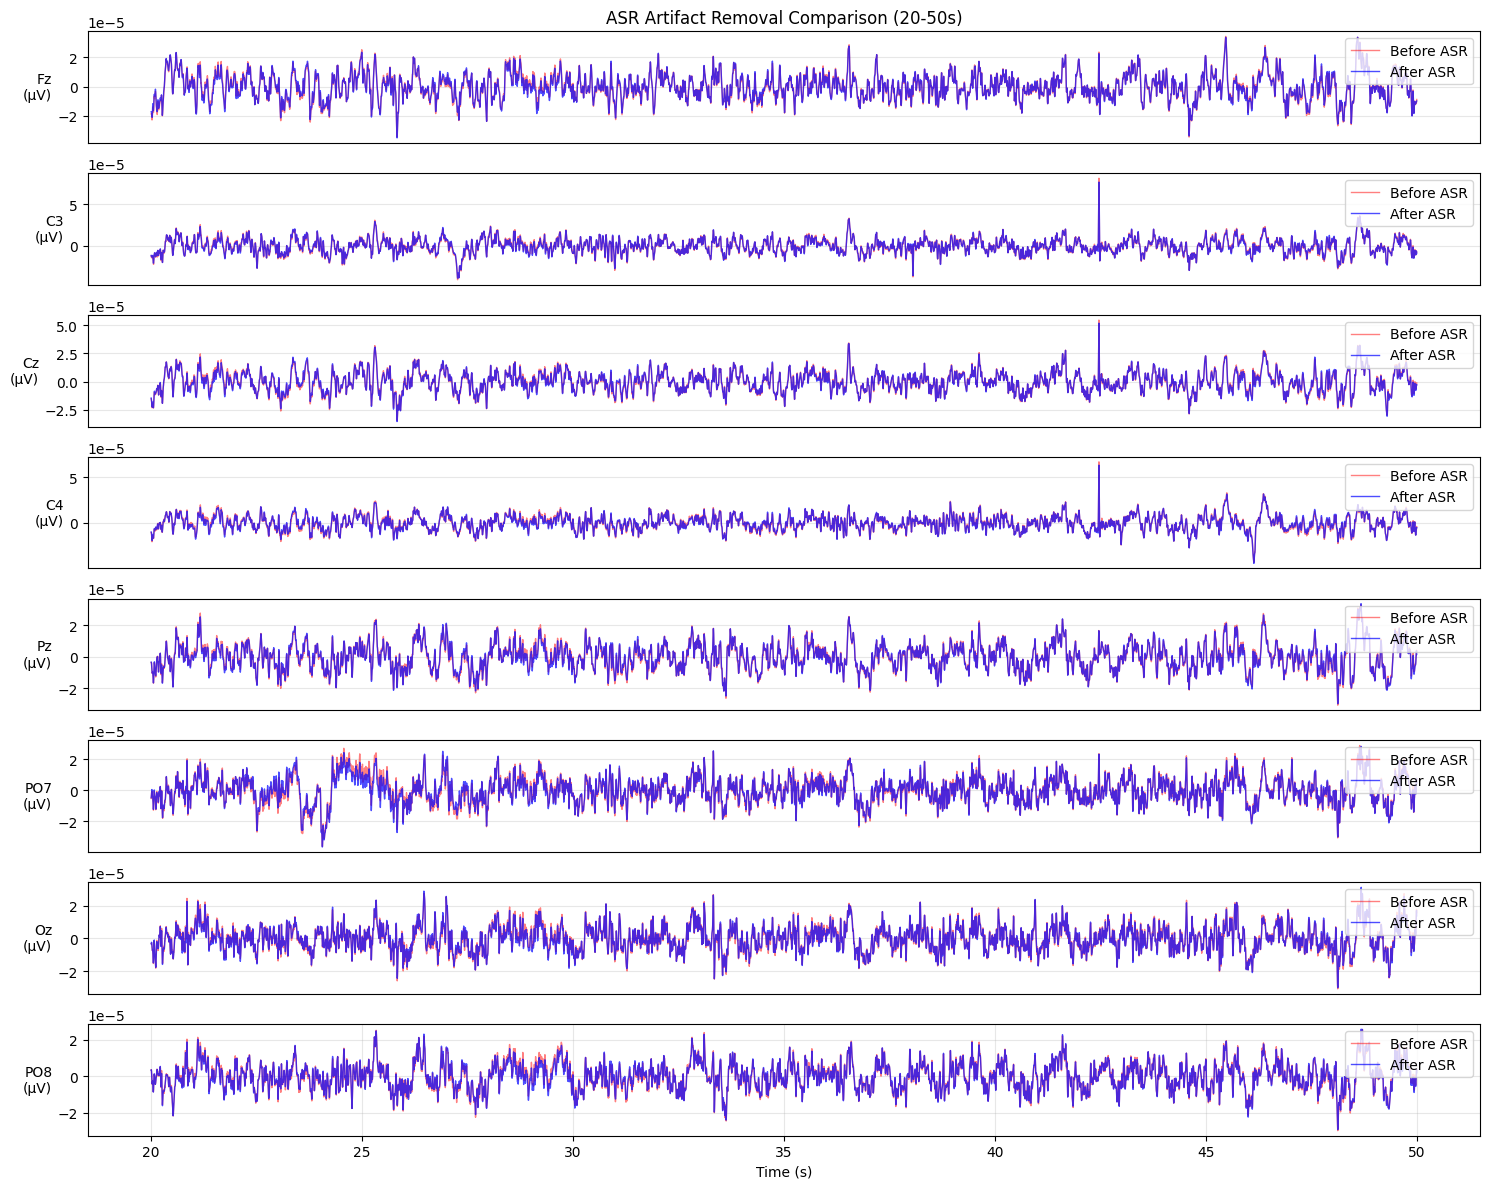

In [4]:
from opencortex.neuroengine.flux.preprocessing.asr import ASRNode

print("\n" + "=" * 60)
print("Applying ASR with 15-second calibration")
print("=" * 60)

# Create preprocessing pipeline with ASR
# Use first 15 seconds for calibration
preprocessing_with_asr = (
        NotchFilterNode((50, 60), name="PowerlineNotch") >>
        BandPassFilterNode(0.5, 40.0, name="BroadBand") >>
        ASRNode(
            sfreq=fs,
            cutoff=5.0,  # Standard cutoff - lower = more aggressive
            calibration_time=5.0,  # Use first 5 seconds,
            calibrate=True,
            name="ASR_Cleaner"
        )
)

# Apply pipeline
print("\nApplying preprocessing pipeline with ASR...")
cleaned_data = preprocessing_with_asr(raw_data)

print("\nCreating comparison plot...")

fig, axes = plt.subplots(len(chs), 1, figsize=(15, 12))

# Show a 10-second window where artifacts might be visible
start_time = 20  # seconds
end_time = 50  # seconds
start_sample = int(start_time * fs)
end_sample = int(end_time * fs)
times_segment = np.arange(start_sample, end_sample) / fs

for i, ch in enumerate(chs):
    ax = axes[i]

    # Get data segments
    raw_segment = raw_data.get_data(picks=[ch])[0, start_sample:end_sample]
    cleaned_segment = cleaned_data.get_data(picks=[ch])[0, start_sample:end_sample]

    # Plot
    ax.plot(times_segment, raw_segment, 'r-', alpha=0.5, label='Before ASR', linewidth=1)
    ax.plot(times_segment, cleaned_segment, 'b-', alpha=0.7, label='After ASR', linewidth=1)

    ax.set_ylabel(f'{ch}\n(µV)', rotation=0, ha='right', va='center')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

    if i == 0:
        ax.set_title(f'ASR Artifact Removal Comparison ({start_time}-{end_time}s)')
    if i == len(chs) - 1:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticks([])

plt.tight_layout()
plt.show()

## Making Epochs

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 3.50 Hz
- Upper transition bandwidth: 3.50 Hz
- Filter length: 237 samples (0.948 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 31.50 Hz)
- Filter length: 8251 samples (33.004 s)

Not setting metadata

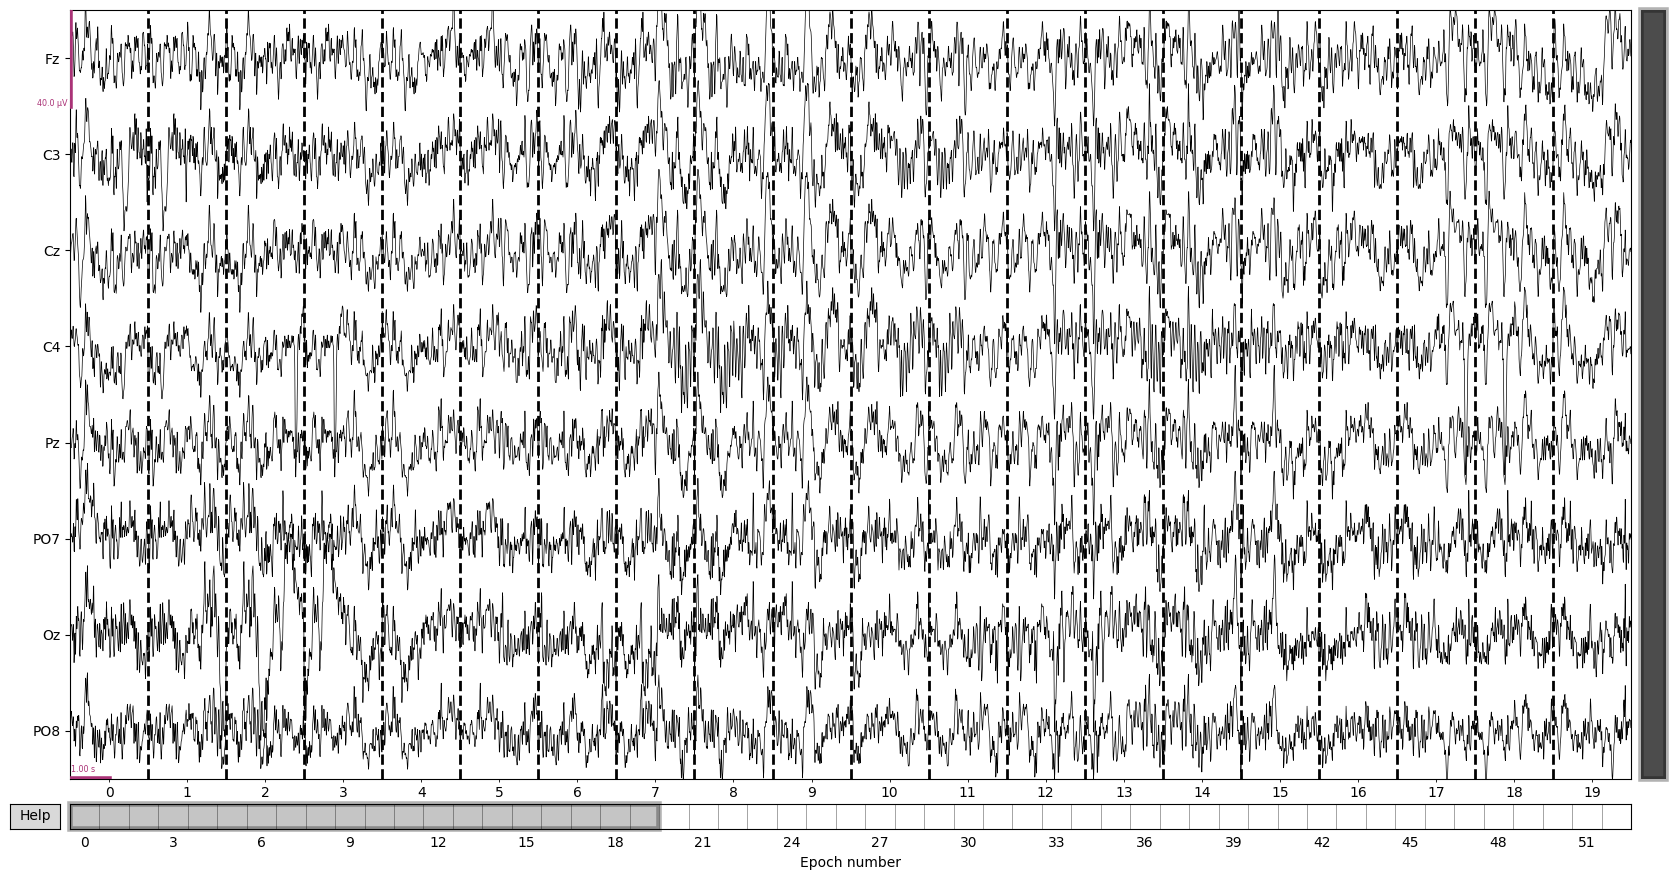

In [5]:
pipeline_overlapping = Sequential(
    NotchFilterNode((50, 60), name="PowerlineNotch"),
    BandPassFilterNode(0.1, 30.0, name="ERPBand"),
    EpochingNode(
        mode='fixed_overlap',
        duration=2.0,  # 2 second windows
        overlap=1.0,  # 1 second overlap (50%)
        baseline=None,  # No baseline
        name='OverlapEpochs'
    ),
    name="OverlappingEpochs"
)

epochs = pipeline_overlapping(raw_data)

# Plot epochs
epochs.plot()
plt.show()